In [1]:
### Define file paths ###
import os 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import math
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm.notebook import tqdm  # specific for Jupyter
import sys
import cv2

def get_model(device, output_dim=2):   
    # 1. Load Pre-trained Model
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    
    # 2. Freeze the 'Body' (Feature Extractor)
    for param in model.parameters():
        param.requires_grad = False
        
    # 3. Replace the 'Head' (Classifier -> Regressor)
    num_ftrs = model.fc.in_features  # 512
    
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 256),
        nn.ReLU(),
        nn.Dropout(0.2),            # Drop 20% of neurons to prevent overfitting
        nn.Linear(256, output_dim)  # Output: [Force, Angle]
    )
    
    # Move to GPU/CPU
    model = model.to(device)
    return model


EXP_NAME = r'TPE_20251218A01_N=265x2_e-5rps_1cycle_TwoPulse_e-2fps_LooseStart'
TRAJ_DIR = r'M:\Archive\Proj_TPE\Disk_traj_files'
BOND_DIR = r'M:\Archive\Proj_TPE\Contact_bond_files'
IMG_DIR = os.path.join(r'N:\PROJ_TPE', EXP_NAME)
F_traj = pd.read_pickle(os.path.join(TRAJ_DIR,  EXP_NAME +'.pkl'))
F_bond = pd.read_pickle(os.path.join(BOND_DIR, 'CONTACT_BOND_'+ EXP_NAME +'.pkl'))


test_model_path = r'O:\LJJ202107\LJJ Jupyter Notebook Collection\training and logistics\training\contact_force_regression_test_0130_finetuned.pth'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_model(DEVICE)
model.load_state_dict(torch.load(test_model_path))


<All keys matched successfully>

In [2]:
############## UTILS #######################

def rotate_image(image, angle_degrees):
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle_degrees, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return rotated

def crop_top_center_square(image, center, radius):
    h, w = image.shape[:2]
    side = int(radius)
    x1 = max(center[0] - side // 2, 0)
    x2 = min(center[0] + side // 2, w)
    y1 = 0
    y2 = min(side, h)
    return image[y1:y2, x1:x2]

def append_ij_angle_to_pdata(pdata):
    dx = pdata['xj'].to_numpy() - pdata['xi'].to_numpy()
    dy = pdata['yj'].to_numpy() - pdata['yi'].to_numpy()
    pdata = pdata.copy()
    pdata['beta'] = np.arctan2(dy, dx)
    return pdata

def crop_circle_with_mask_float(img):
    h, w = img.shape
    center = (w // 2, h // 2)
    radius = min(center[0], center[1])
    Y, X = np.ogrid[:h, :w]
    mask = (X - center[0])**2 + (Y - center[1])**2 <= radius**2
    return img * mask  # retain float values

def get_disk_img(pdata, img):
       
    img = img[250:1200, :]  # crop top/bottom

    entry = pdata.copy()
    x = int(np.around(entry['xi']))
    y = int(np.around(entry['yi']))
    r = int(entry['ri'])

    h, w = img.shape[:2]
    y1, y2 = max(0, y - r), min(h, y + r)
    x1, x2 = max(0, x - r), min(w, x + r)
    img_crop = img[y1:y2, x1:x2]

    if img_crop.shape[0] == 0 or img_crop.shape[1] == 0:
        raise ValueError("Cropped region is empty. Check particle location or radius.")

    return img_crop

In [9]:
F_bond = append_ij_angle_to_pdata(F_bond)

# Testing mode: set to True to only process first 5 rows and plot results
test_mode = 0

# Collect all processed images and metadata
all_images = []
all_metadata = []

for frame in range(max(F_bond.frame)+1):   
    sys.stdout.write(f"\rProcessing frame: {frame}")
    sys.stdout.flush() 
    
    frame_data = F_bond[F_bond['frame'] == frame]
    image_path = os.path.join(IMG_DIR, 'Ib_'+str(frame+1)+'.png')
    img = cv2.imread(image_path)[:,:,0]
    
    # In test mode, only process first 5 particles
    if test_mode:
        frame_data = frame_data.iloc[:5]
    
    # Process each particle in the frame
    for idx, pdata in frame_data.iterrows():
        # 1. Crop the particle (disk image)
        try:
            img_crop = get_disk_img(pdata, img)
        except ValueError as e:
            print(f"Skipping particle {idx}: {e}")
            continue
        
        # 2. Mask the region outside the circle
        img_masked = crop_circle_with_mask_float(img_crop)
        
        # 3. Get particle radius and center
        r = int(pdata['ri'])
        center = (img_crop.shape[1] // 2, img_crop.shape[0] // 2)
        
        # 4. Rotate by beta degrees (contact angle)
        rotation_angle = pdata['beta'] * 180 / np.pi + 90  # Convert radians to degrees
        img_rotated = rotate_image(img_masked, rotation_angle)
        
        # 5. Crop the top center square
        img_final = crop_top_center_square(img_rotated, center, r)
        
        # Store image and metadata
        all_images.append(img_final)
        all_metadata.append({
            'idx': idx,
            'frame': frame,
            'beta': pdata['beta'],
            'xi': pdata['xi'],
            'yi': pdata['yi'],
            'ri': pdata['ri']
        })
        
        # Plot in test mode
        if test_mode:
            plt.figure(figsize=(10, 4))
            plt.subplot(1, 2, 1)
            plt.imshow(img_masked, cmap='gray')
            plt.title(f'Particle {idx}: Masked (beta={pdata["beta"]:.4f})')
            plt.axis('off')
            
            plt.subplot(1, 2, 2)
            plt.imshow(img_final, cmap='gray')
            plt.title(f'Particle {idx}: Resized (64x64)')
            plt.axis('off')
            plt.tight_layout()
            plt.show()

print(f"\nTotal contacts processed: {len(all_images)}")

Processing frame: 1000
Total contacts processed: 401153


In [10]:
# Define transforms (same as training)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

BATCH_SIZE = 32
print(f"Total images to process: {len(all_images)}")
sys.stdout.flush()
print(f"Processing in batches of {BATCH_SIZE}...")
sys.stdout.flush()

# Run model predictions with batch processing
# Process images in batches to avoid loading all into memory at once
model.eval()
all_predictions = []

with torch.no_grad():
    for batch_idx in range(0, len(all_images), BATCH_SIZE):
        batch_end = min(batch_idx + BATCH_SIZE, len(all_images))
        batch_size_actual = batch_end - batch_idx
        
        # Convert only this batch of images to PIL and apply transforms
        batch_images = []
        for i in range(batch_idx, batch_end):
            img = all_images[i]
            # Convert to PIL
            pil_img = Image.fromarray((img * 255).astype(np.uint8)) if img.max() <= 1.0 else Image.fromarray(img.astype(np.uint8))
            # Apply transforms
            tensor_img = data_transform(pil_img)
            batch_images.append(tensor_img)
        
        # Stack batch and move to device
        batch_tensor = torch.stack(batch_images).to(DEVICE)
        batch_predictions = model(batch_tensor)
        batch_predictions = batch_predictions.cpu().numpy()
        all_predictions.append(batch_predictions)
        
        print(f"Processed batch {batch_idx // BATCH_SIZE + 1}: samples {batch_idx} to {batch_end}")
        sys.stdout.flush()
        
        # Explicitly free memory
        del batch_tensor, batch_images
        torch.cuda.empty_cache() if torch.cuda.is_available() else None

# Concatenate all predictions
predictions = np.vstack(all_predictions)

# Store predictions with metadata
for i, meta in enumerate(all_metadata):
    meta['force_pred'] = predictions[i, 0]
    meta['angle_pred'] = predictions[i, 1]

print(f"\nCompleted! Processed {len(all_metadata)} particles with ResNet predictions")
sys.stdout.flush()

Total images to process: 401153
Processing in batches of 32...
Processed batch 1: samples 0 to 32
Processed batch 2: samples 32 to 64
Processed batch 3: samples 64 to 96
Processed batch 4: samples 96 to 128
Processed batch 5: samples 128 to 160
Processed batch 6: samples 160 to 192
Processed batch 7: samples 192 to 224
Processed batch 8: samples 224 to 256
Processed batch 9: samples 256 to 288
Processed batch 10: samples 288 to 320
Processed batch 11: samples 320 to 352
Processed batch 12: samples 352 to 384
Processed batch 13: samples 384 to 416
Processed batch 14: samples 416 to 448
Processed batch 15: samples 448 to 480
Processed batch 16: samples 480 to 512
Processed batch 17: samples 512 to 544
Processed batch 18: samples 544 to 576
Processed batch 19: samples 576 to 608
Processed batch 20: samples 608 to 640
Processed batch 21: samples 640 to 672
Processed batch 22: samples 672 to 704
Processed batch 23: samples 704 to 736
Processed batch 24: samples 736 to 768
Processed batch 25

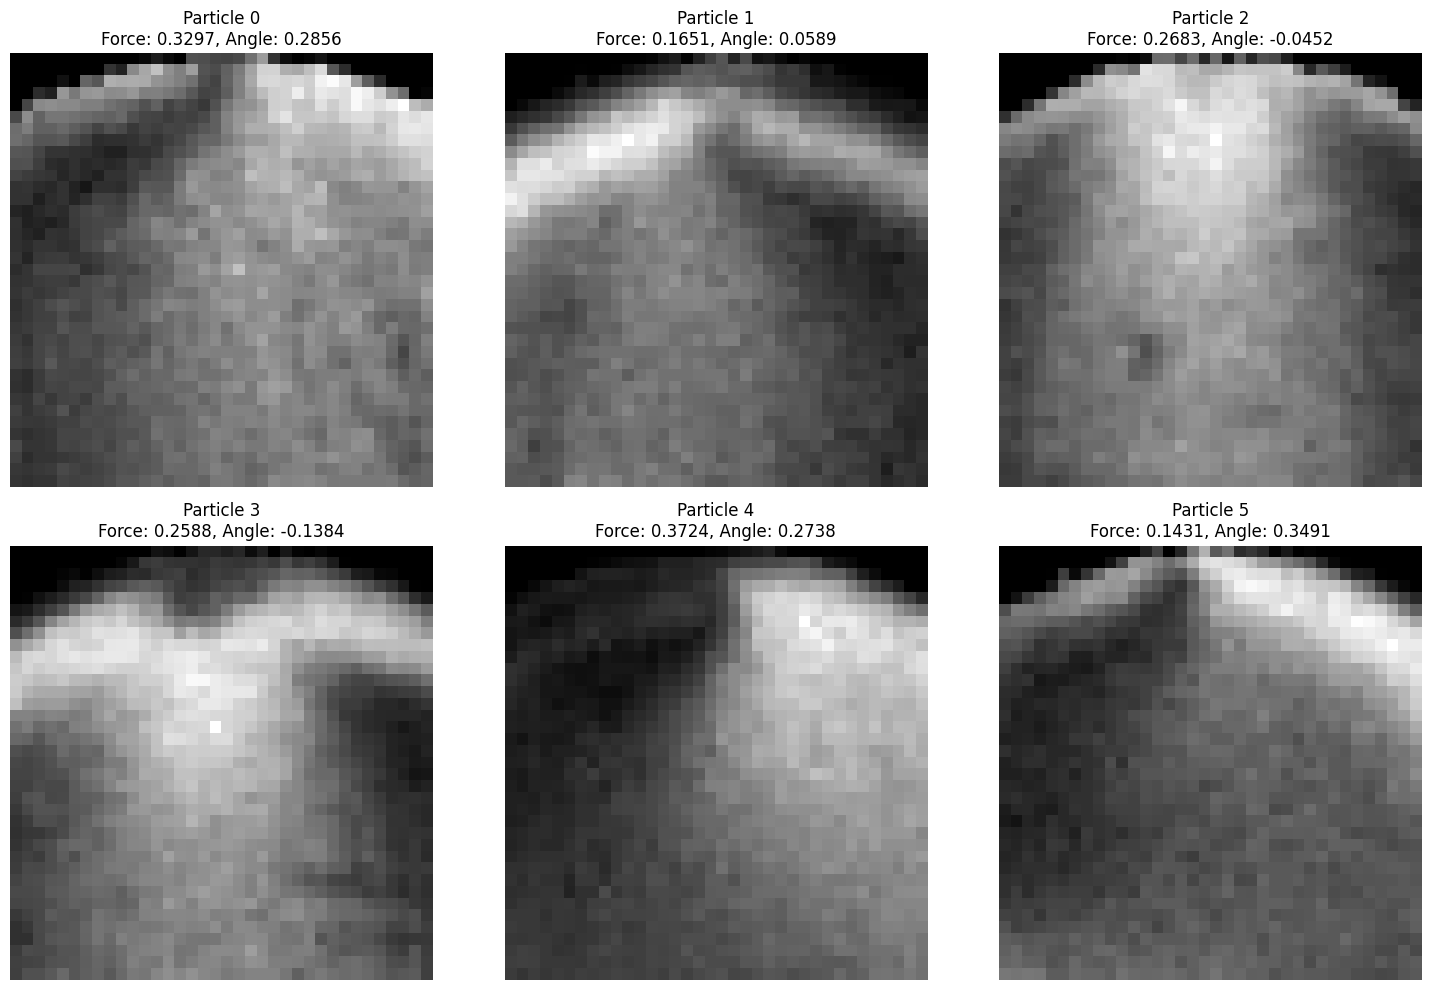

In [12]:
# Plot a few crops with predictions
num_to_plot = min(6, len(all_images))
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i in range(num_to_plot):
    img = all_images[i]
    meta = all_metadata[i]
    
    # Normalize image for display if needed
    if img.max() <= 1.0:
        img_display = (img * 255).astype(np.uint8)
    else:
        img_display = img.astype(np.uint8)
    
    axes[i].imshow(img_display, cmap='gray')
    axes[i].set_title(f"Particle {meta['idx']}\nForce: {meta['force_pred']:.4f}, Angle: {meta['angle_pred']:.4f}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()


### Append ResNet Initial guess

In [13]:
# Append predictions back to F_bond
F_bond_pred = F_bond.copy()

# Initialize new columns with NaN
F_bond_pred['force_pred'] = np.nan
F_bond_pred['angle_pred'] = np.nan

# Fill in predictions at corresponding indices
for meta in all_metadata:
    idx = meta['idx']
    F_bond_pred.loc[idx, 'force_pred'] = meta['force_pred']
    F_bond_pred.loc[idx, 'angle_pred'] = meta['angle_pred']

F_bond_pred.loc[F_bond_pred['ri']<40, 'force_pred'] = F_bond_pred.loc[F_bond_pred['ri']<40, 'force_pred'] * 0.8 

F_bond_pred.to_pickle(os.path.join(BOND_DIR, 'CONTACT_BOND_'+ EXP_NAME + '_with_ResNet_preds.pkl'))
F_bond_pred.head()

,i,xi,yi,ri,j,xj,yj,rj,j_on_boundary,frame,prob,singular,beta
0,2,763.785803,787.585886,37.0,177,702.622726,849.841276,46.0,True,1,0.906694,-1,2.347344
1,2,763.785803,787.585886,37.0,181,791.616532,706.471412,46.0,False,1,0.964086,-1,-1.240278
2,4,1444.177324,779.238407,37.0,3,1410.284580,849.518754,37.0,True,1,0.943778,-1,2.020144
3,4,1444.177324,779.238407,37.0,89,1471.867307,707.557759,37.0,False,1,0.956087,-1,-1.202159
4,5,1270.341680,519.911424,37.0,123,1356.421504,528.715232,46.0,False,1,0.931564,-1,0.101921


In [6]:
F_bond_pred = pd.read_pickle(os.path.join(BOND_DIR, 'CONTACT_BOND_'+ EXP_NAME + '_with_ResNet_preds.pkl'))
F_bond_pred.head()

,i,xi,yi,ri,j,xj,yj,rj,j_on_boundary,frame,prob,singular,beta,force_pred,angle_pred
0,2,763.785803,787.585886,37.0,177,702.622726,849.841276,46.0,True,1,0.906694,-1,2.347344,0.263748,0.285622
1,2,763.785803,787.585886,37.0,181,791.616532,706.471412,46.0,False,1,0.964086,-1,-1.240278,0.132070,0.058929
2,4,1444.177324,779.238407,37.0,3,1410.284580,849.518754,37.0,True,1,0.943778,-1,2.020144,0.214650,-0.045213
3,4,1444.177324,779.238407,37.0,89,1471.867307,707.557759,37.0,False,1,0.956087,-1,-1.202159,0.207060,-0.138410
4,5,1270.341680,519.911424,37.0,123,1356.421504,528.715232,46.0,False,1,0.931564,-1,0.101921,0.297911,0.273847
